In [1]:
from imblearn.metrics import geometric_mean_score
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras import optimizers,regularizers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
np.random.seed(13)
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from __future__ import division
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize

files=['AAPL','AMZN','PEP','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX','BKNG','ADBE','AMGN','TXN','AVGO','PYPL','GILD','COST','QCOM']       
#files=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX','ADBE','AMGN','TXN','AVGO','PYPL','GILD','COST','QCOM']       
  
prices=list()
sentiment=list()
for file in files:
    param = {
        'q': file, # Stock symbol (ex: "AAPL")
        'i': "900", # Interval size in seconds ("86400" = 1 day intervals)
        'x': "NASD", # INDEXNASDAQStock exchange symbol on which stock is traded (ex: "NASD")
        'p': "2Y" # Period (Ex: "1Y" = 1 year)
        }
    sentimentVector =  pd.read_csv('/home/andrea/Desktop/NLFF/intrinioDatasetUpdated/Sentiment/'+file+'.csv')
    price= pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalDatasetUpdated/'+file+'.csv')
    #sentimentVector =  pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalSentiment/'+file+'.csv')
    #price= pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalDataset/indexes'+file+'.csv')
    #alignment of data
    maxdata=max(sentimentVector['initTime'])
    mindata=min(sentimentVector['initTime'])
    price['Unnamed: 0'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['Unnamed: 0']]
    price['Unnamed: 0'] = [row-timedelta(hours=8) for row in price['Unnamed: 0']]
    price=price[price['Unnamed: 0']>=mindata]
    price=price[price['Unnamed: 0']<=maxdata]
    print(file)
    sentimentVector=sentimentVector.drop(['Unnamed: 0', 'initTime' ], axis=1)
    meanvector=np.concatenate((sentimentVector,pd.rolling_mean(sentimentVector,5)),axis=1)
    meanvector=np.concatenate((meanvector,pd.rolling_mean(sentimentVector,10)),axis=1)
    meanvector=np.concatenate((meanvector,pd.rolling_mean(sentimentVector,15)),axis=1)
    meanvector=np.concatenate((meanvector,pd.rolling_mean(sentimentVector,20)),axis=1)
    price=price.drop(['Unnamed: 0'],axis=1)
    #['macd','macds', 'boll_ub', 'boll_lb','rsi_6','rsi_12','vr_6_sma','wr_10','wr_6''close_10_sma''tr''middle_{}_sma'
    #df['dma'] = df['close_10_sma'] - df['close_50_sma'] pdi'] = cls._get_pdi(df, 14)df['mdi'] = cls._get_mdi(df, 14)
    #df['dx'] = cls._get_dx(df, 14) df['adx'] = df['dx_6_ema'] df['adxr'] = df['adx_6_ema']]
    #
    sentiment.append(meanvector)
    prices.append(price)

/home/andrea/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


AAPL


/home/andrea/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5,center=False).mean()
/home/andrea/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
/home/andrea/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=15,center=False).mean()
/home/andrea/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=20,center=False).mean()


AMZN
PEP
GOOGL
MSFT
FB
INTC
CSCO
CMCSA
NVDA
NFLX
BKNG
ADBE
AMGN
TXN
AVGO
PYPL
GILD
COST
QCOM


In [2]:
def smote(x,y):
    
    X_resampled, y_resampled = SMOTE().fit_sample(x, y)
    #print('check',sum(y_resampled)/len(y_resampled))
    return X_resampled,y_resampled
def balance(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    nindex=min(len(posindex[0]),len(negindex[0]))

    #for i in range(1,nindex):
    yt=np.concatenate((y[posindex[0][0:nindex]],y[negindex[0][0:nindex]]))
    xt=np.concatenate((x[posindex[0][0:nindex]],x[negindex[0][0:nindex]]))
    
    return xt,yt

def balanceup(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    
    if(len(posindex[0])!=0 and len(negindex[0])!=0):
       
        nindex=max(len(posindex[0]),len(negindex[0]))
        mini=min(len(posindex[0]),len(negindex[0]))
        diff=nindex-mini
        u=0
        for i in range(0,mini):
            yt.append(y[posindex[0][i]])
            yt.append(y[negindex[0][i]])
            xt.append(x[posindex[0][i]])
            xt.append(x[negindex[0][i]])
        #print('first',sum(yt)/len(yt)) 
        if(len(posindex[0])>len(negindex[0])):
            toextract=negindex
            enter=posindex
        else:
            toextract=posindex
            enter=negindex
        if(diff!=0 and len(toextract[0])!=0):
            for i in range(0,diff):
                r=np.random.randint(0,len(toextract))
                yt.append(y[toextract[0][r]])
                xt.append(x[toextract[0][r]])
                yt.append(y[enter[0][mini+i]])
                xt.append(x[enter[0][mini+i]])
    else:
        #print('Unbalance')
        u=1
        xt=x
        yt=y
    #print(sum(yt)/len(yt))              
    return xt,yt,u
                    

In [ ]:
def buildModel(l,n,d,le):
    opt=optimizers.Adam(lr=le)
    model = Sequential()  
    model.add(Dense(n, input_dim=151,activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dropout(d))
    model.add(Dense(math.floor(n/2), activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU())
    model.add(Dropout(d))
    model.add(Dense(math.floor(n/4), activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(3, activation='softmax')) 
    
    model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

    return model
def reset_weights(model):
    session=K.get_session()
    for layer in model.layers:
        if(hasattr(layer,'kernel_initializer')):
            layer.kernel.initializer.run(session=session)
            
def toOneHot(y):
    yhot=[]
    for i in range(0,len(y)):
        if(y[i]==1):
            yhot.append([0,0,1])
        elif(y[i]==-1):
            yhot.append([1,0,0])
        elif(y[i]==0):
            yhot.append([0,1,0])
        else:
            print('Problem in hot vector')
    return yhot


Working on... AAPL
15.571701720841297
0.005338458253266777
working on d,u and l 0.5 64 0.01


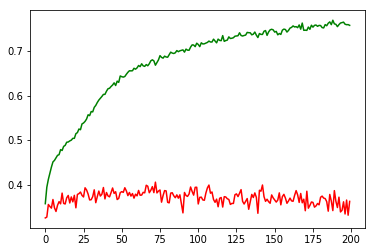

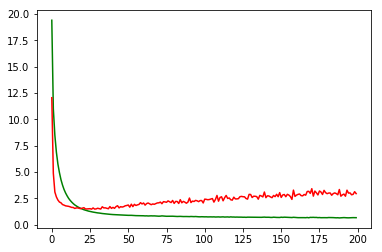

working on d,u and l 0.5 64 0.01


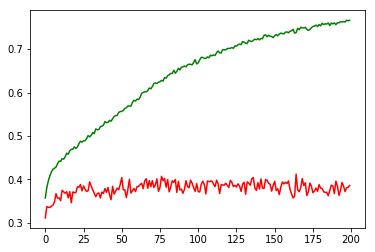

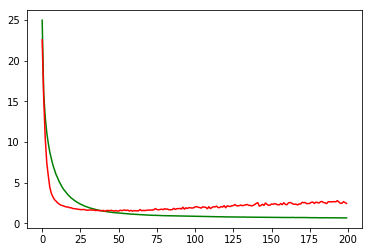

working on d,u and l 0.5 64 0.01


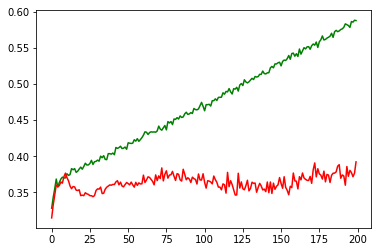

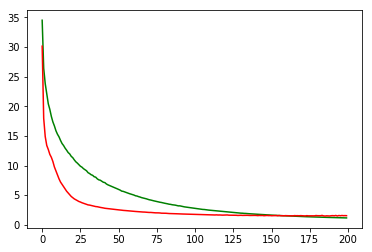

working on d,u and l 0.5 64 0.05


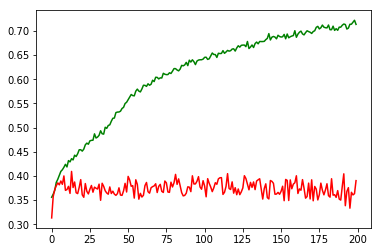

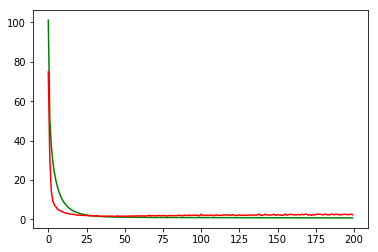

working on d,u and l 0.5 64 0.05


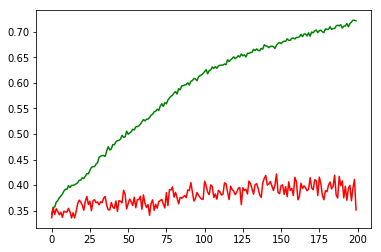

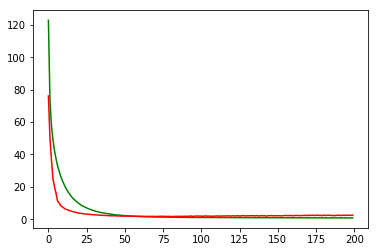

working on d,u and l 0.5 64 0.05


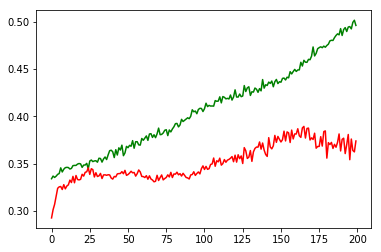

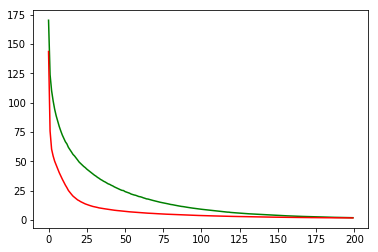

working on d,u and l 0.5 128 0.01


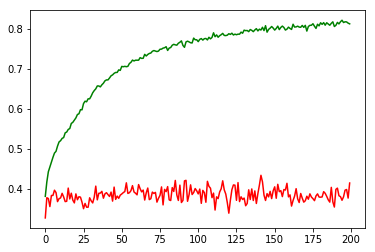

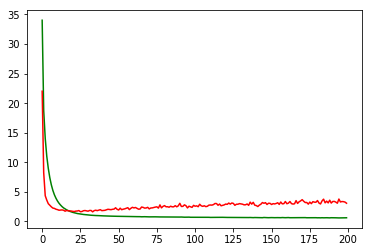

working on d,u and l 0.5 128 0.01


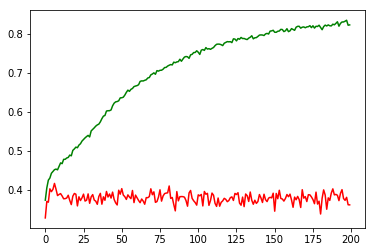

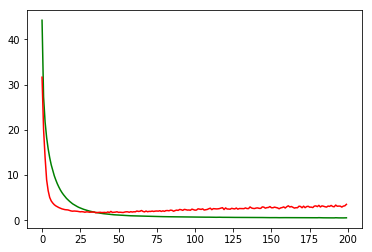

working on d,u and l 0.5 128 0.01


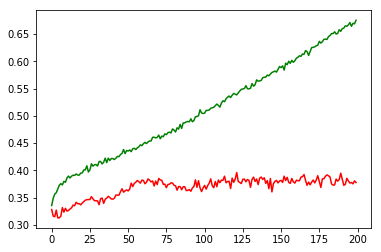

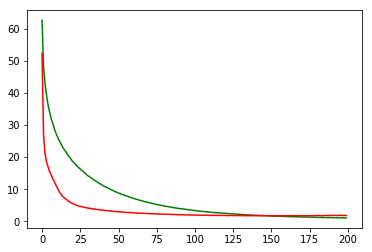

working on d,u and l 0.5 128 0.05


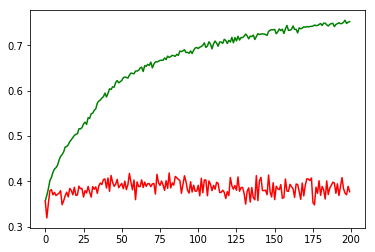

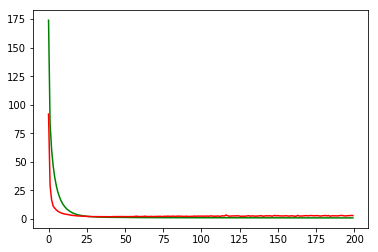

working on d,u and l 0.5 128 0.05


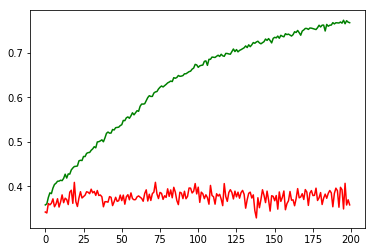

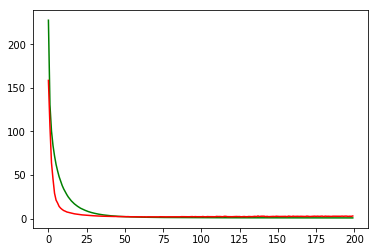

working on d,u and l 0.5 128 0.05


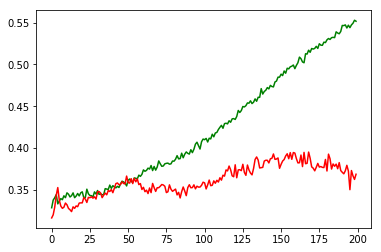

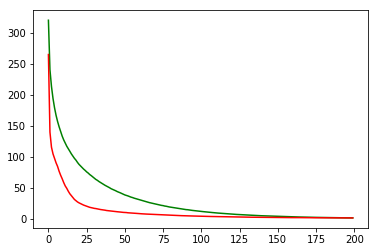

best model u,l,d,learn 0.01 128 0.5 0.001
Chart for BEST MODEL FOR: AAPL


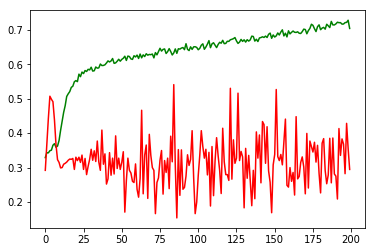

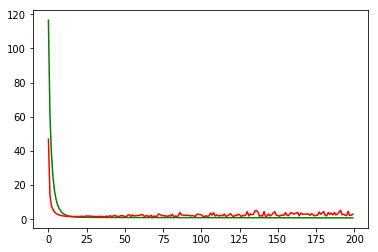

G-score: 0.5352191653502177
Accuracy 0.2946902671746448
0.29469026548672567
Window: 140
[[134  32  29]
 [543  27  23]
 [138  32 172]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... AMZN
11.150617492631287
0.0007590184265374819
working on d,u and l 0.5 64 0.01
Non balance


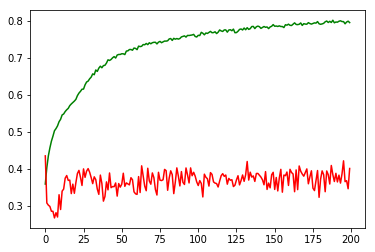

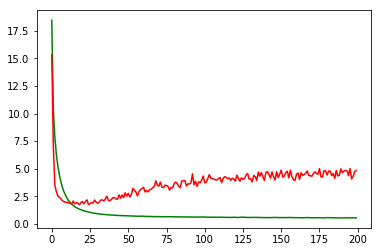

working on d,u and l 0.5 64 0.01
Non balance


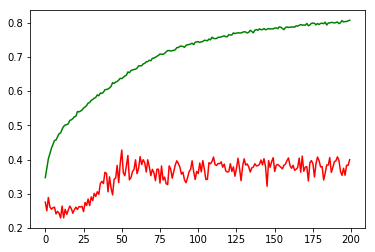

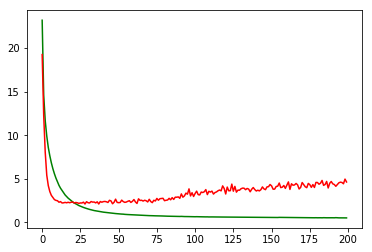

working on d,u and l 0.5 64 0.01
Non balance


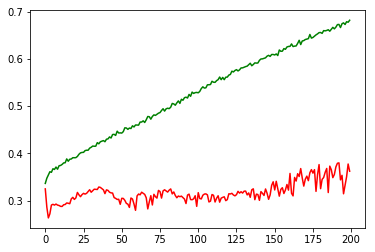

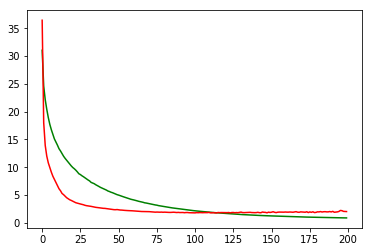

working on d,u and l 0.5 64 0.05
Non balance


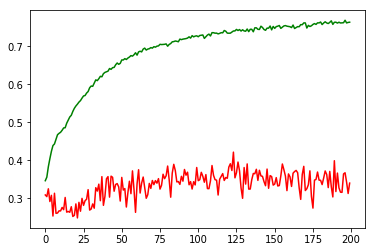

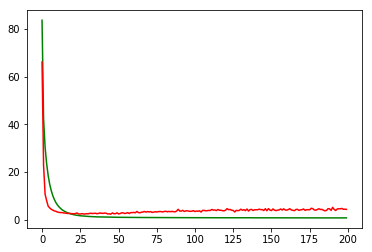

working on d,u and l 0.5 64 0.05
Non balance


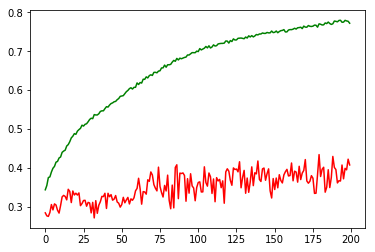

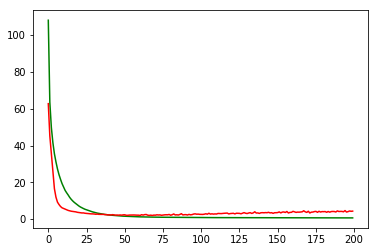

working on d,u and l 0.5 64 0.05
Non balance


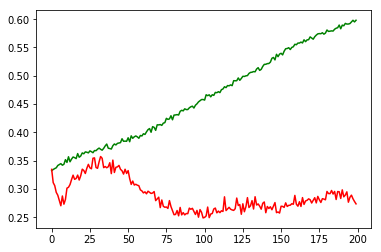

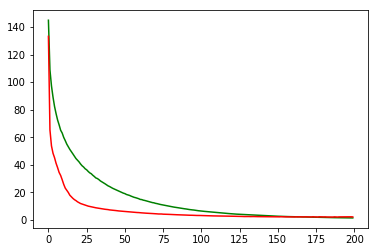

working on d,u and l 0.5 128 0.01
Non balance


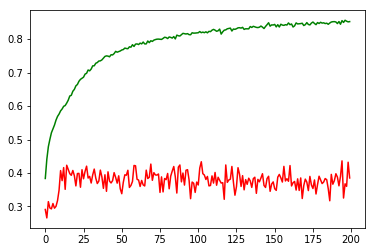

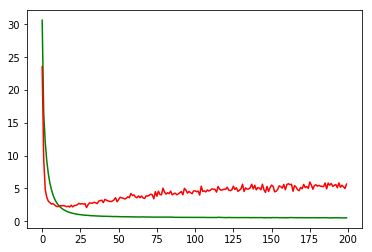

working on d,u and l 0.5 128 0.01
Non balance


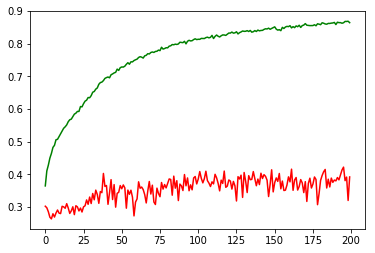

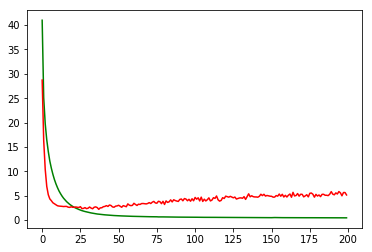

working on d,u and l 0.5 128 0.01
Non balance


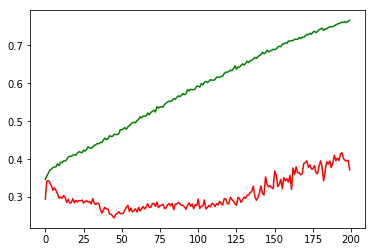

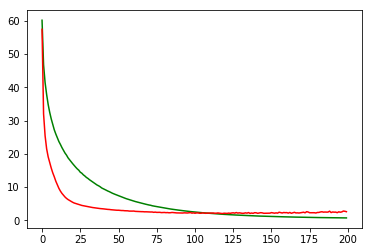

working on d,u and l 0.5 128 0.05
Non balance


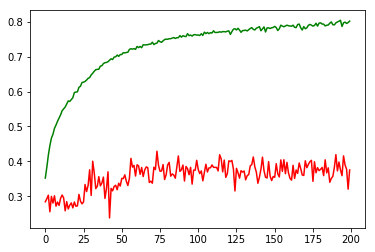

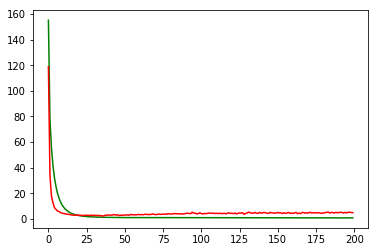

working on d,u and l 0.5 128 0.05
Non balance


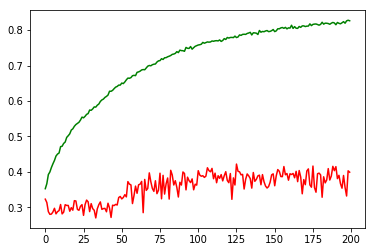

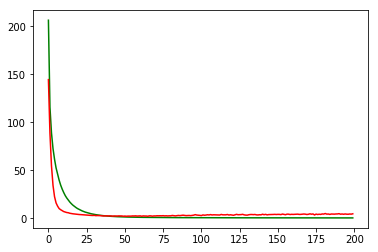

working on d,u and l 0.5 128 0.05
Non balance


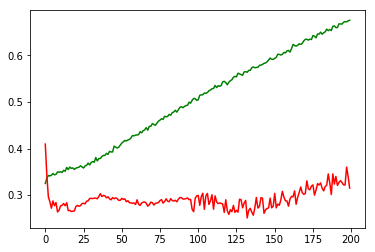

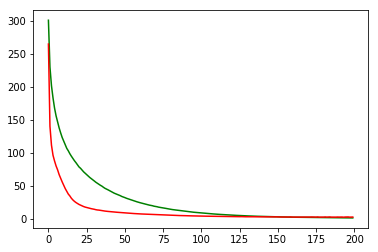

best model u,l,d,learn 0.01 64 0.5 0.0005
Chart for BEST MODEL FOR: AMZN


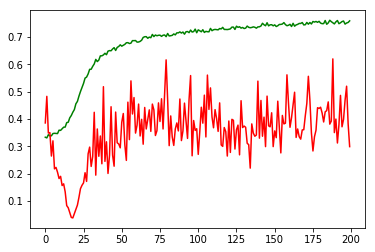

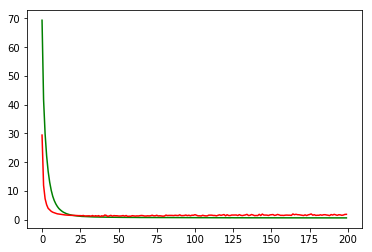

G-score: 0.4262416134916676
Accuracy 0.2985865720169283
0.29858657243816256
Window: 140
[[ 72  69  92]
 [ 26   9   2]
 [425 180 257]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... PEP
5.495274763738178
0.0
working on d,u and l 0.5 64 0.01


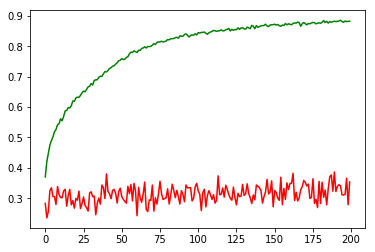

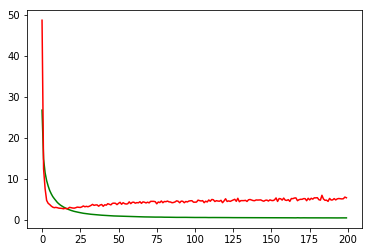

working on d,u and l 0.5 64 0.01


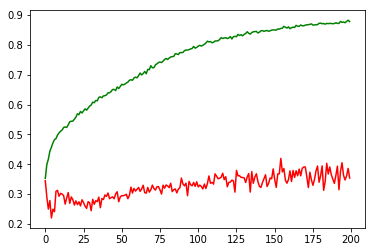

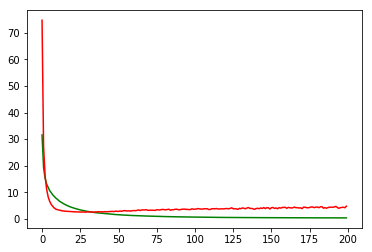

working on d,u and l 0.5 64 0.01


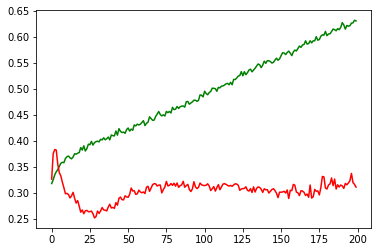

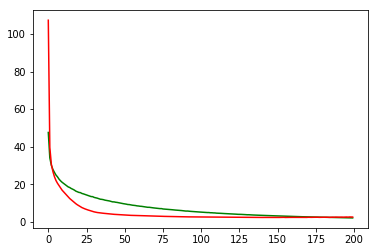

working on d,u and l 0.5 64 0.05


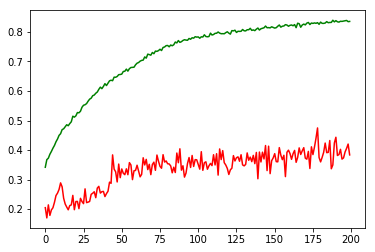

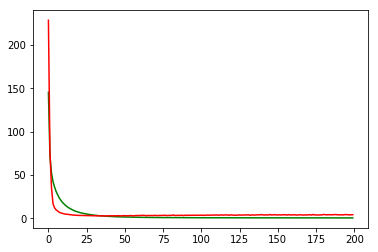

working on d,u and l 0.5 64 0.05


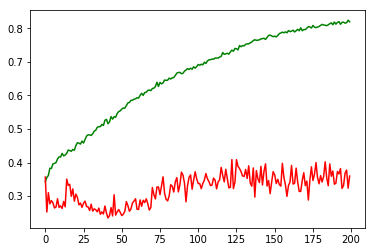

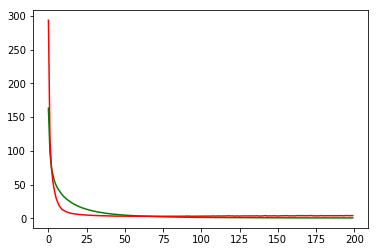

working on d,u and l 0.5 64 0.05


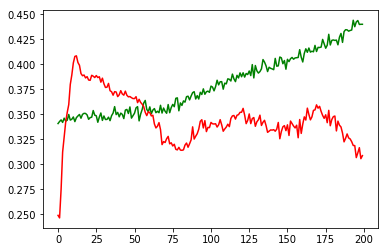

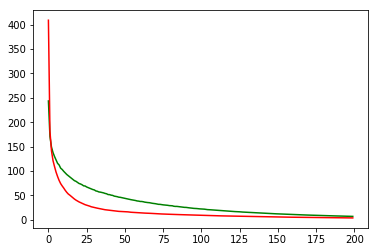

working on d,u and l 0.5 128 0.01


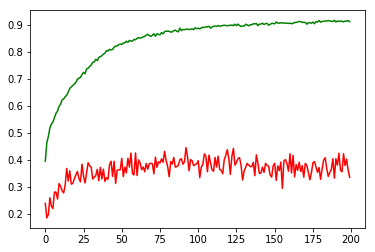

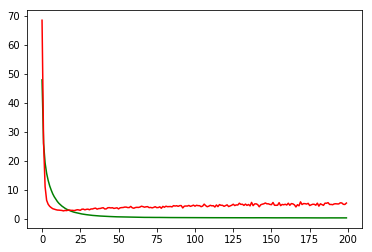

working on d,u and l 0.5 128 0.01


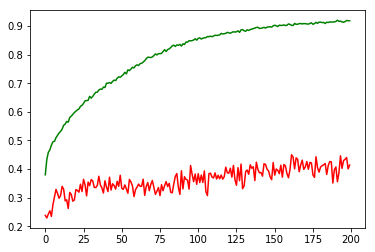

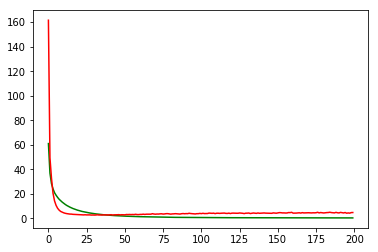

working on d,u and l 0.5 128 0.01


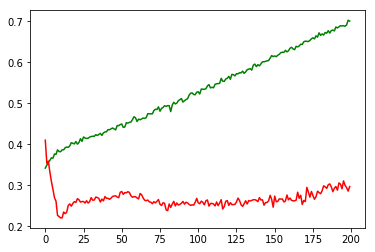

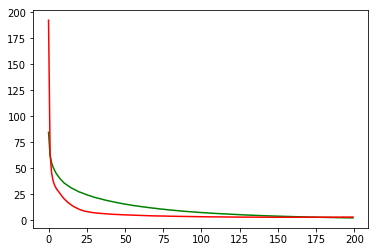

working on d,u and l 0.5 128 0.05


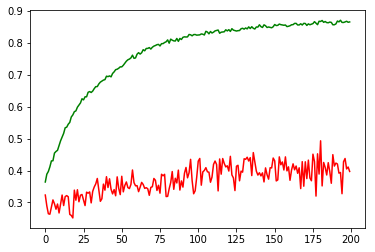

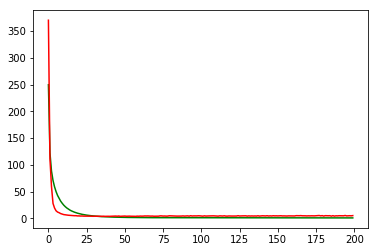

working on d,u and l 0.5 128 0.05


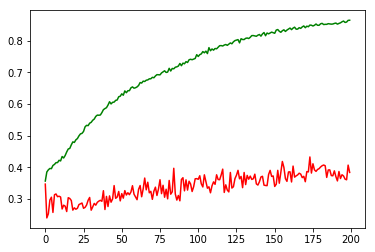

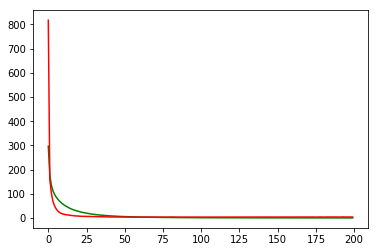

working on d,u and l 0.5 128 0.05


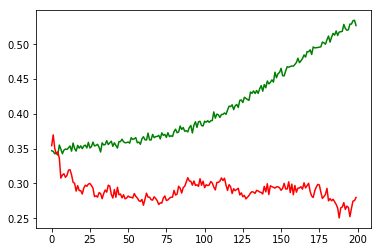

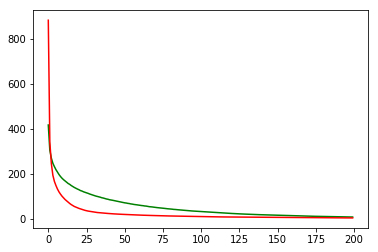

best model u,l,d,learn 0.01 128 0.5 0.0005
Chart for BEST MODEL FOR: PEP


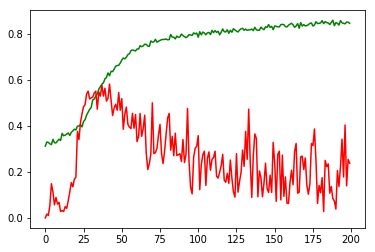

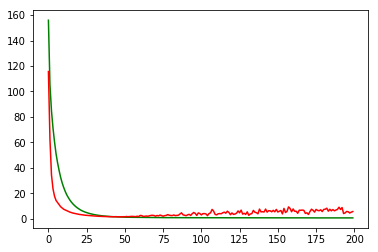

G-score: 0.35127360784062506
Accuracy 0.23809523814101738
0.23809523809523808
Window: 140
[[  0   0   0]
 [105 146   6]
 [ 41 344   9]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... GOOGL
9.280622946926826
0.003477111910863453
working on d,u and l 0.5 64 0.01
Non balance


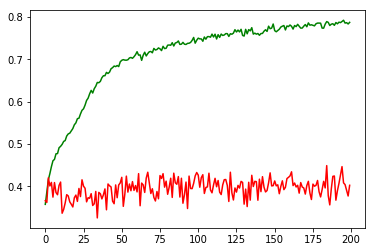

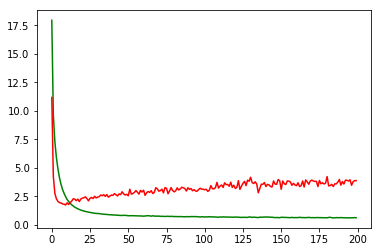

working on d,u and l 0.5 64 0.01
Non balance


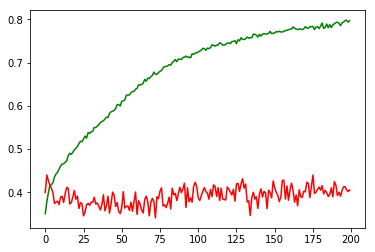

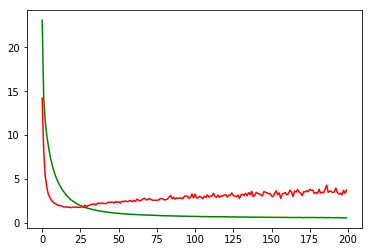

working on d,u and l 0.5 64 0.01
Non balance


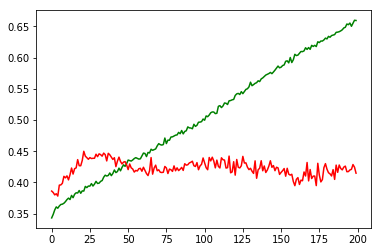

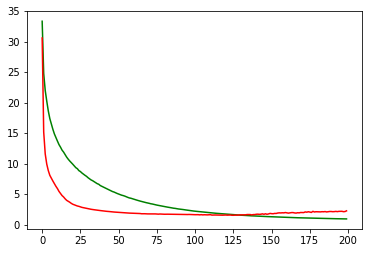

working on d,u and l 0.5 64 0.05
Non balance


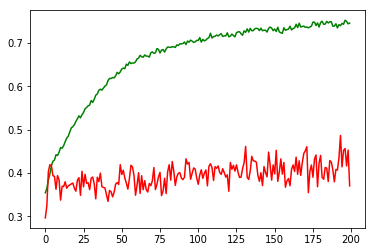

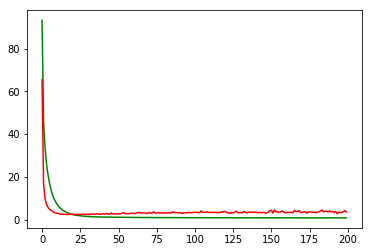

working on d,u and l 0.5 64 0.05
Non balance


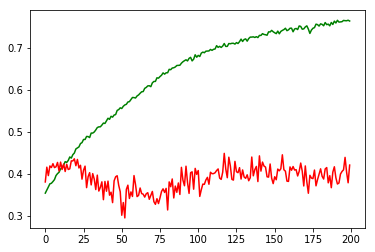

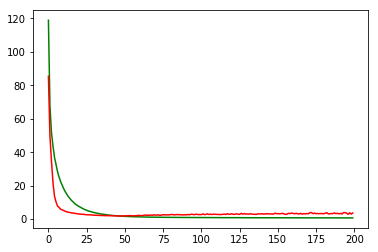

working on d,u and l 0.5 64 0.05
Non balance


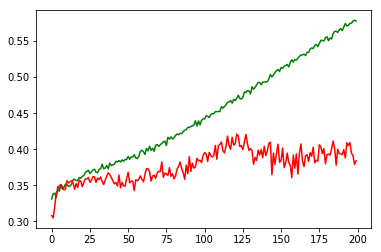

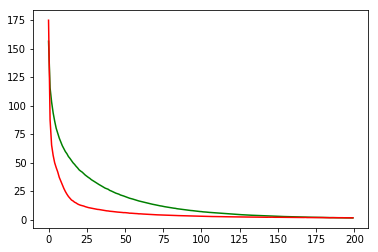

working on d,u and l 0.5 128 0.01
Non balance


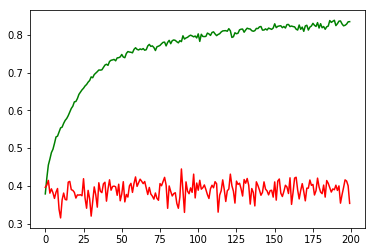

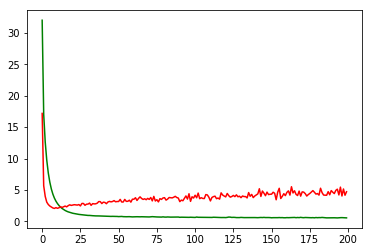

working on d,u and l 0.5 128 0.01
Non balance


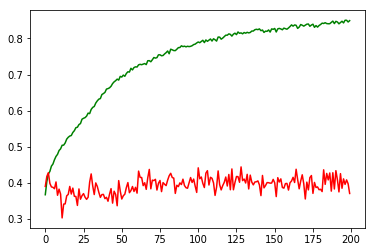

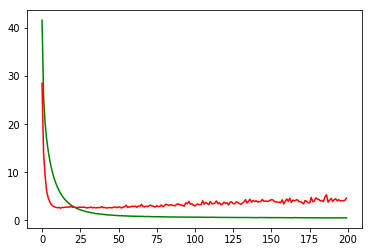

working on d,u and l 0.5 128 0.01
Non balance


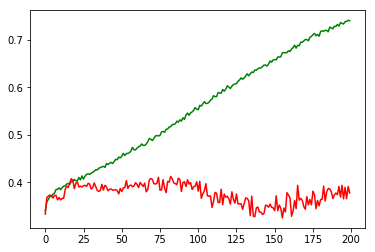

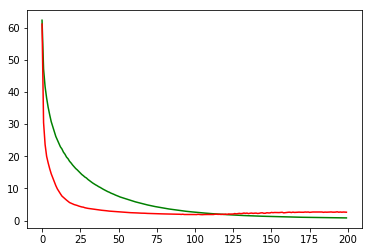

working on d,u and l 0.5 128 0.05
Non balance


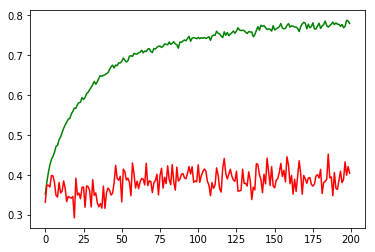

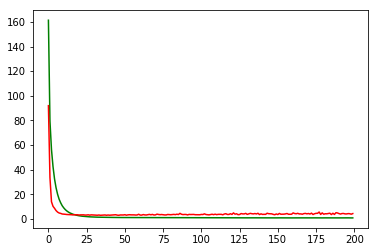

working on d,u and l 0.5 128 0.05
Non balance


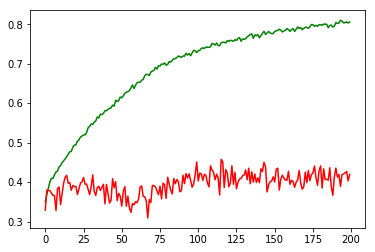

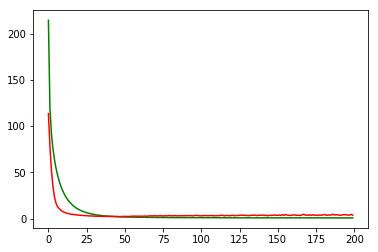

working on d,u and l 0.5 128 0.05
Non balance


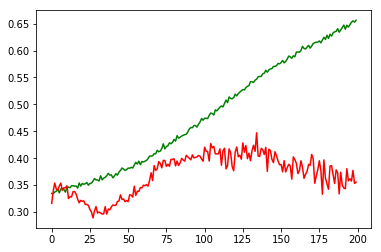

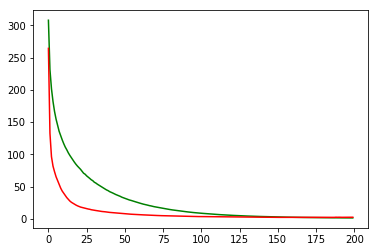

best model u,l,d,learn 0.05 64 0.5 0.0005
Chart for BEST MODEL FOR: GOOGL


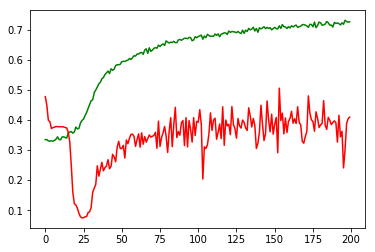

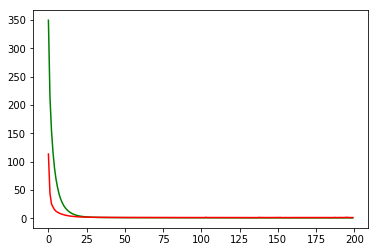

G-score: 0.4464786849279041
Accuracy 0.4097345127732353
0.4097345132743363
Window: 140
[[236  13 178]
 [ 45   1   8]
 [391  32 226]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... MSFT
5.843279709392834
0.0
working on d,u and l 0.5 64 0.01
Non balance


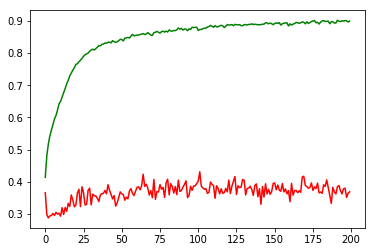

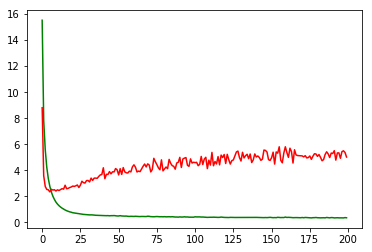

working on d,u and l 0.5 64 0.01
Non balance


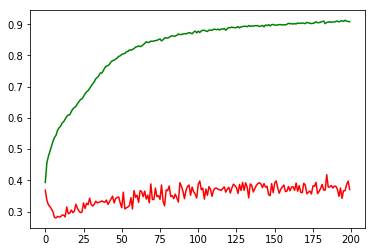

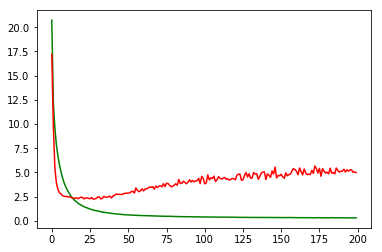

working on d,u and l 0.5 64 0.01
Non balance


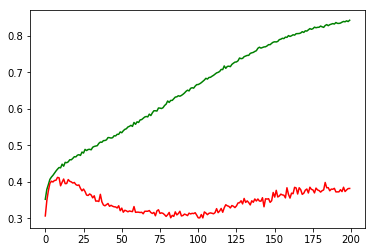

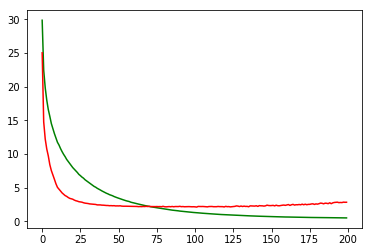

working on d,u and l 0.5 64 0.05
Non balance


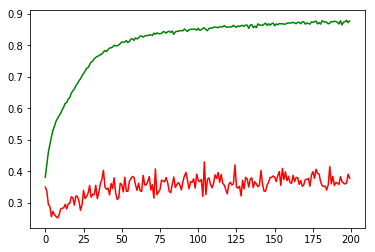

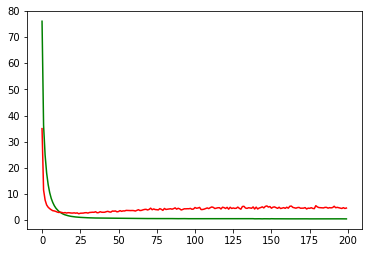

working on d,u and l 0.5 64 0.05
Non balance


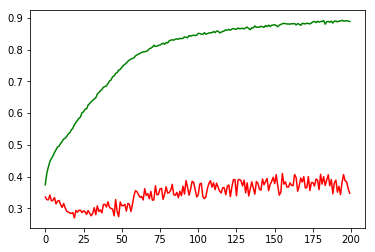

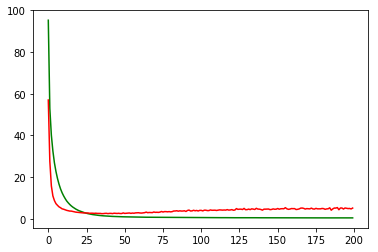

working on d,u and l 0.5 64 0.05
Non balance


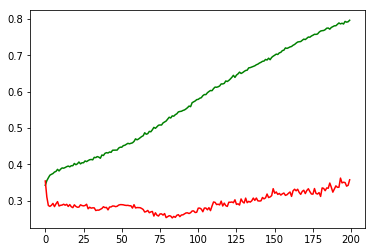

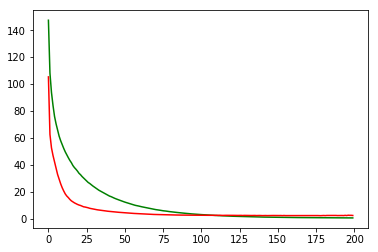

working on d,u and l 0.5 128 0.01
Non balance


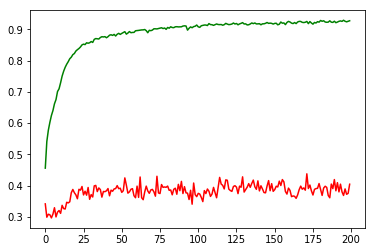

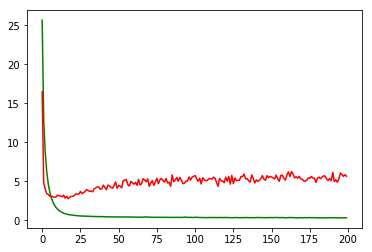

working on d,u and l 0.5 128 0.01
Non balance


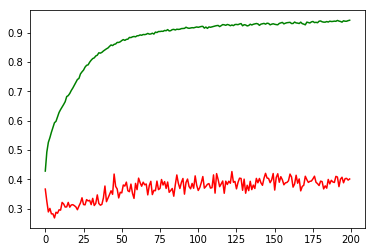

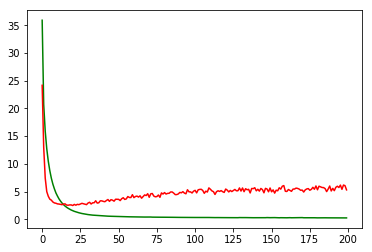

working on d,u and l 0.5 128 0.01
Non balance


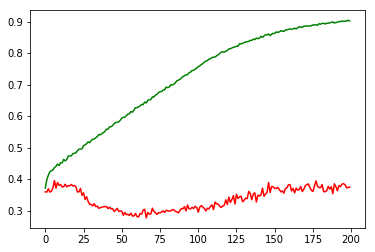

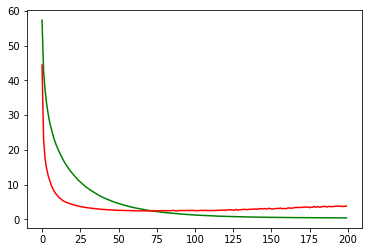

working on d,u and l 0.5 128 0.05
Non balance


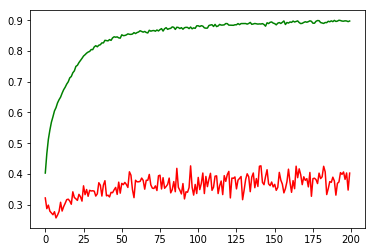

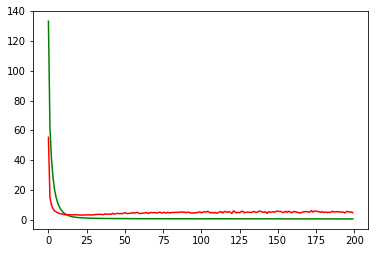

working on d,u and l 0.5 128 0.05
Non balance


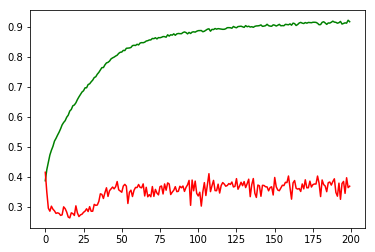

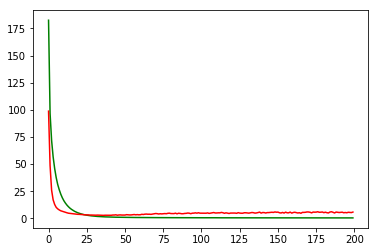

working on d,u and l 0.5 128 0.05
Non balance


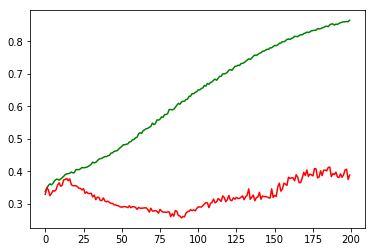

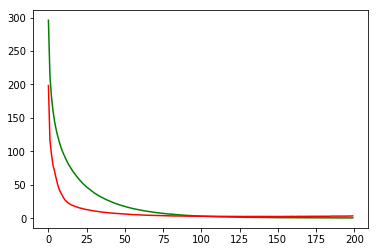

best model u,l,d,learn 0.01 128 0.5 0.0005
Chart for BEST MODEL FOR: MSFT


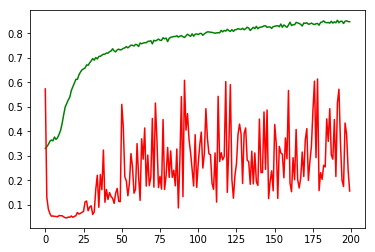

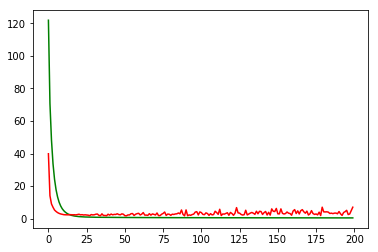

G-score: 0.3151722362305202
Accuracy 0.1557522126531179
0.15575221238938053
Window: 140
[[ 18  48   0]
 [652 157   2]
 [208  44   1]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... FB
12.871078806426938
0.005182421227207363
working on d,u and l 0.5 64 0.01


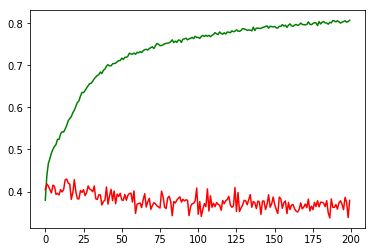

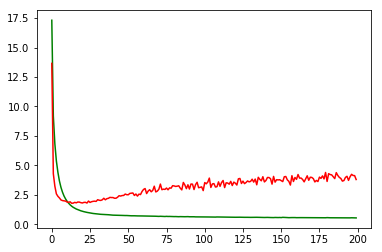

working on d,u and l 0.5 64 0.01


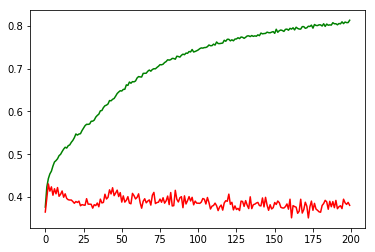

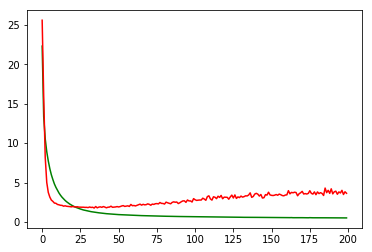

working on d,u and l 0.5 64 0.01


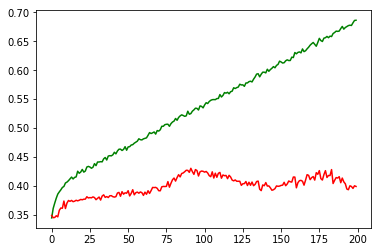

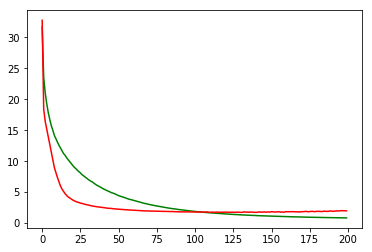

working on d,u and l 0.5 64 0.05


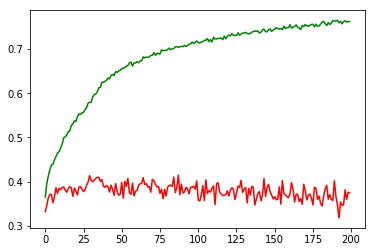

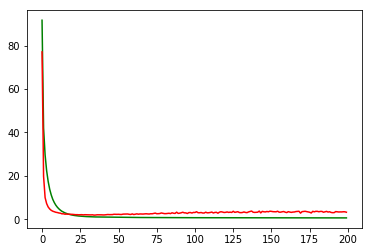

working on d,u and l 0.5 64 0.05


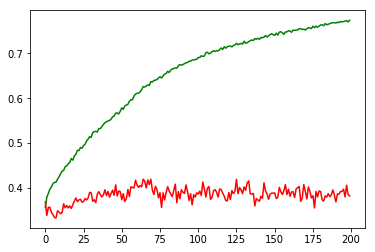

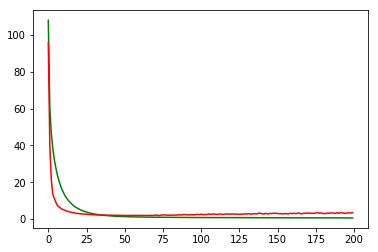

working on d,u and l 0.5 64 0.05


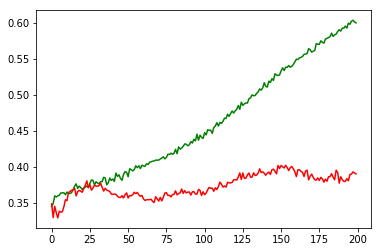

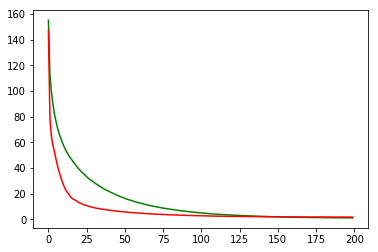

working on d,u and l 0.5 128 0.01


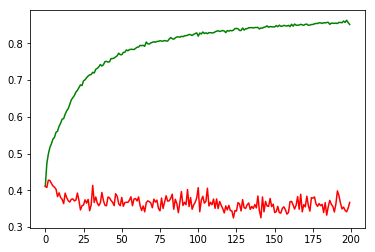

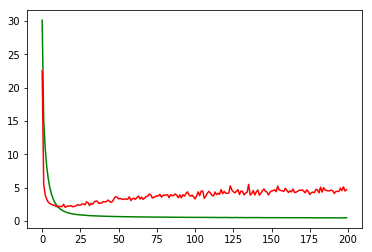

working on d,u and l 0.5 128 0.01


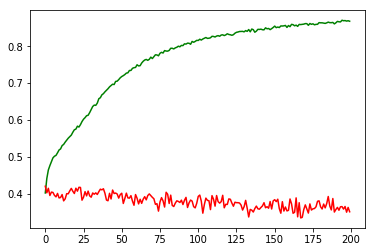

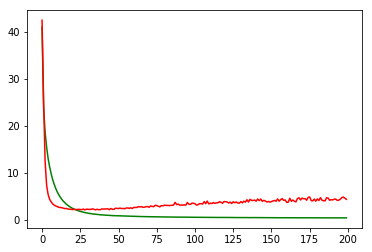

working on d,u and l 0.5 128 0.01


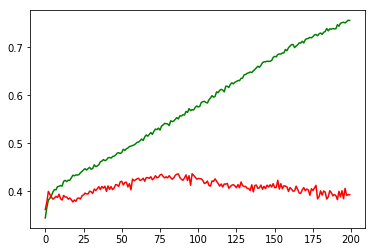

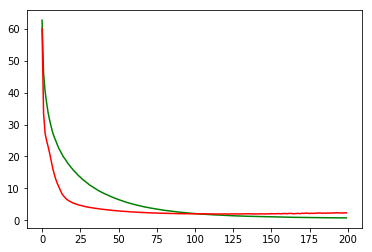

working on d,u and l 0.5 128 0.05


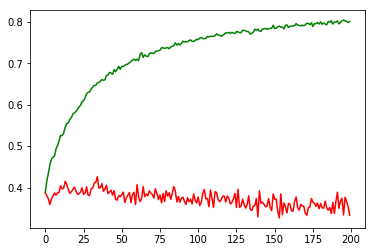

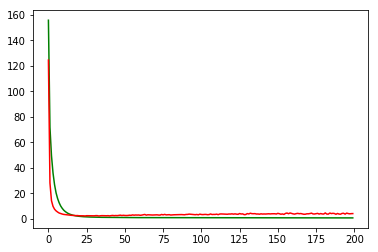

working on d,u and l 0.5 128 0.05


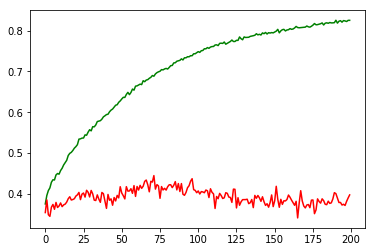

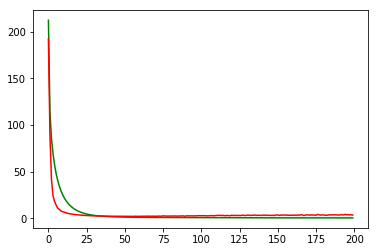

working on d,u and l 0.5 128 0.05


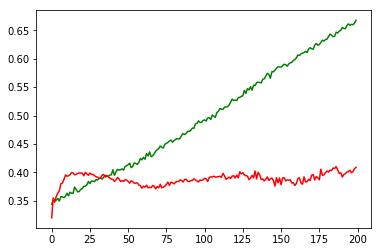

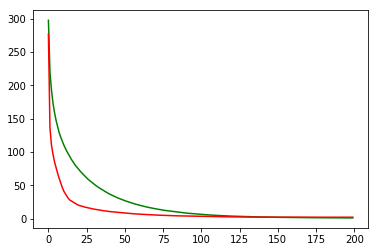

best model u,l,d,learn 0.05 128 0.5 0.0001
Chart for BEST MODEL FOR: FB


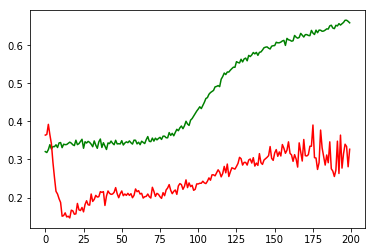

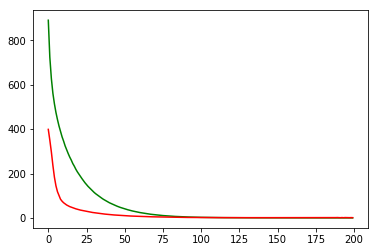

G-score: 0.5205048713940639
Accuracy 0.32685512367491165
0.32685512367491165
Window: 140
[[ 59  42   6]
 [271  89  28]
 [289 126 222]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... INTC
6.746031746031759
0.009064539521396952
working on d,u and l 0.5 64 0.01


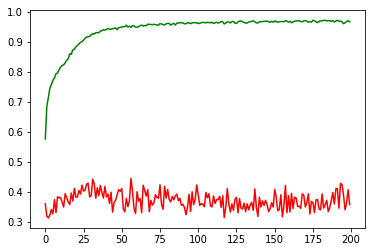

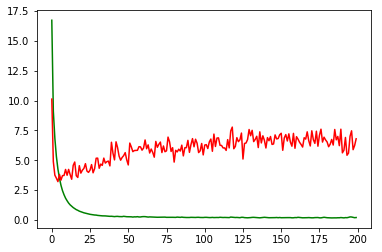

working on d,u and l 0.5 64 0.01


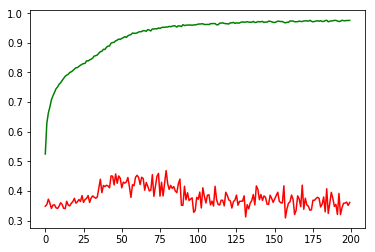

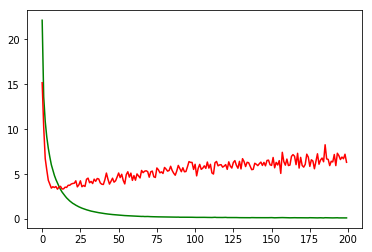

working on d,u and l 0.5 64 0.01


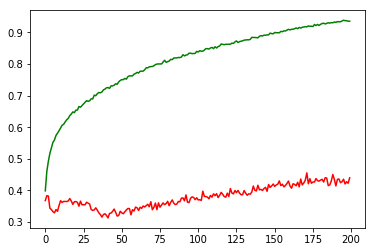

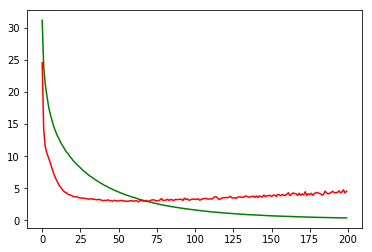

working on d,u and l 0.5 64 0.05


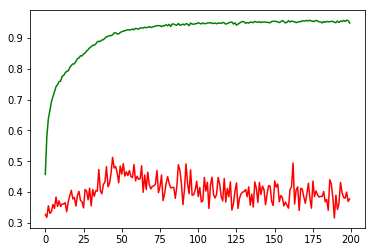

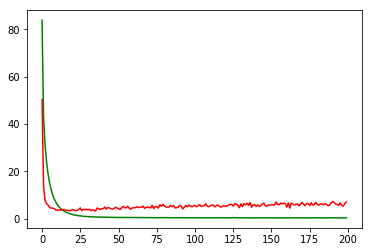

working on d,u and l 0.5 64 0.05


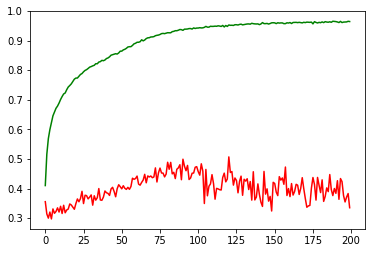

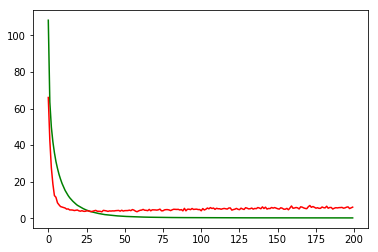

working on d,u and l 0.5 64 0.05


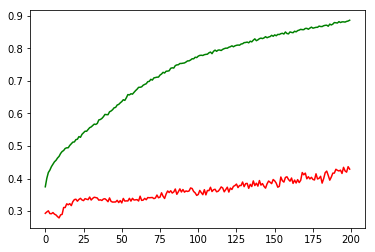

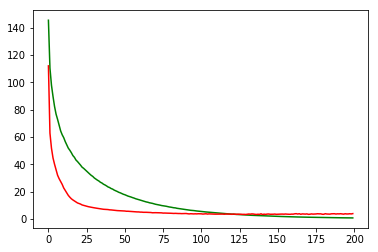

working on d,u and l 0.5 128 0.01


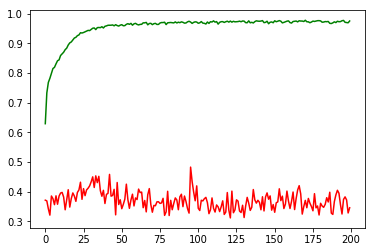

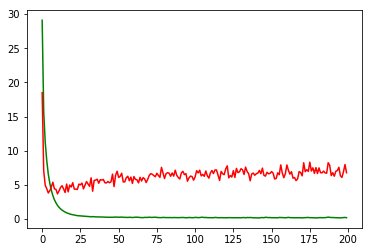

working on d,u and l 0.5 128 0.01


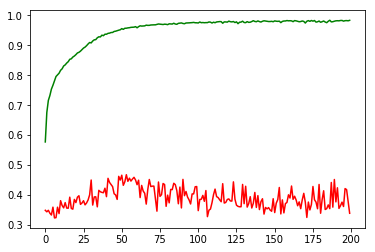

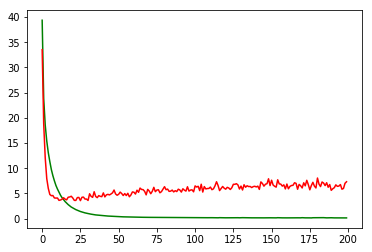

working on d,u and l 0.5 128 0.01


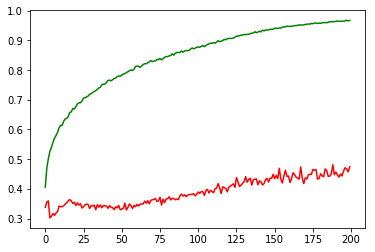

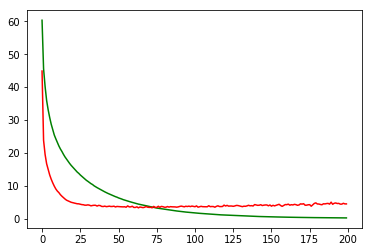

working on d,u and l 0.5 128 0.05


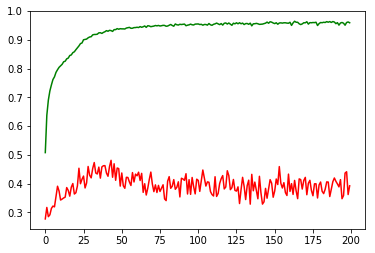

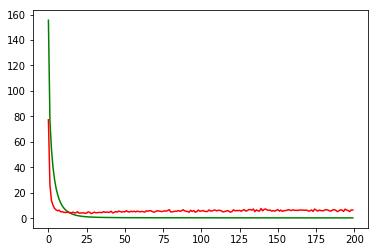

working on d,u and l 0.5 128 0.05


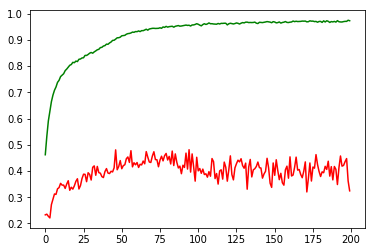

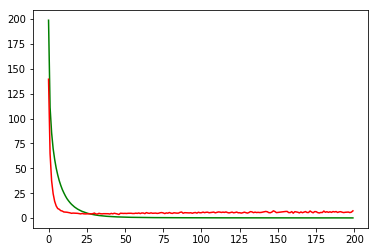

working on d,u and l 0.5 128 0.05


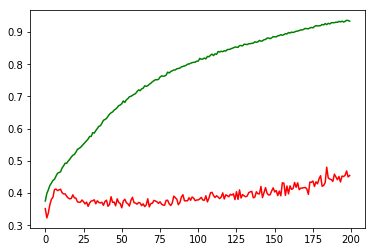

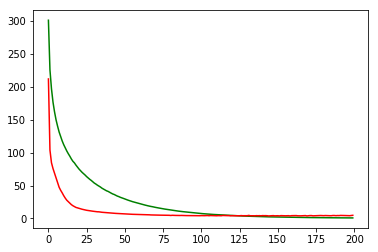

best model u,l,d,learn 0.01 128 0.5 0.0001
Chart for BEST MODEL FOR: INTC


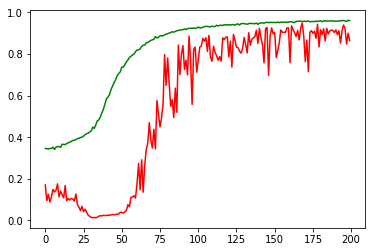

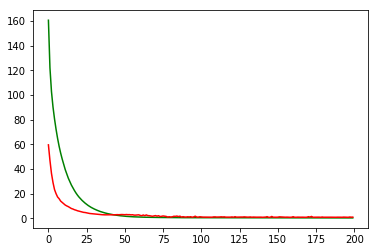

G-score: 0.511333253404534
Accuracy 0.8639575952775908
0.8639575971731449
Window: 140
[[  7  21   0]
 [103 971  18]
 [  0  12   0]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... CSCO
6.455652128779988
0.0
working on d,u and l 0.5 64 0.01
Non balance
Non balance
Non balance
Non balance
Non balance


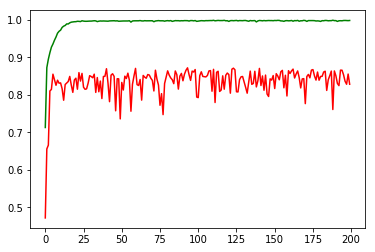

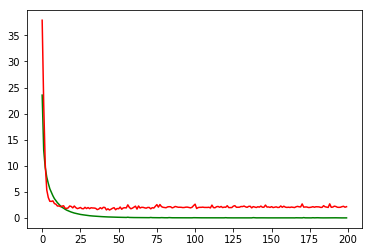

working on d,u and l 0.5 64 0.01
Non balance
Non balance
Non balance
Non balance
Non balance


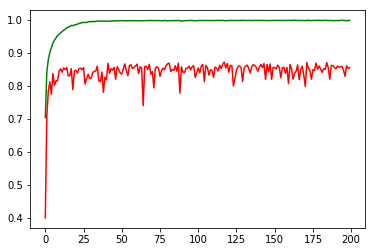

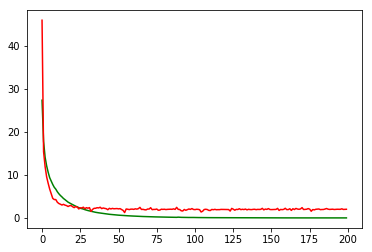

working on d,u and l 0.5 64 0.01
Non balance
Non balance
Non balance
Non balance
Non balance


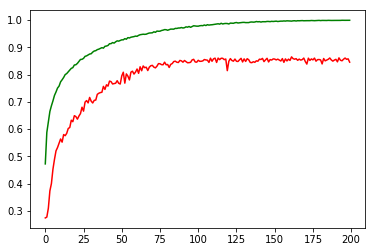

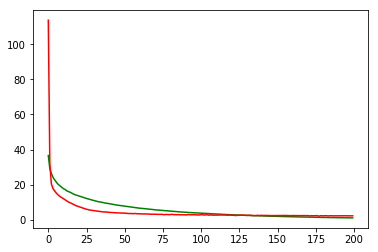

working on d,u and l 0.5 64 0.05
Non balance
Non balance
Non balance
Non balance
Non balance


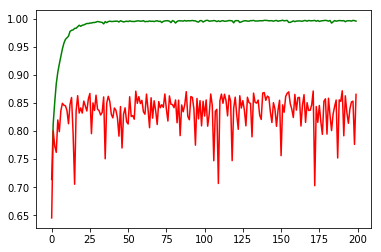

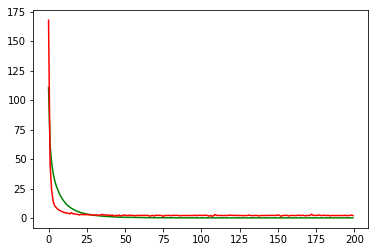

working on d,u and l 0.5 64 0.05
Non balance
Non balance
Non balance
Non balance
Non balance


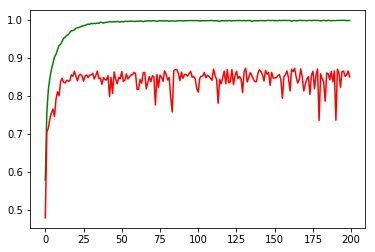

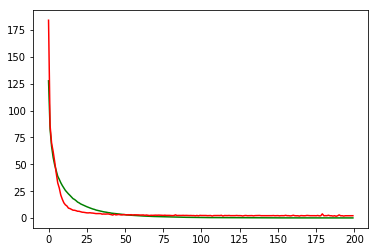

working on d,u and l 0.5 64 0.05
Non balance
Non balance
Non balance
Non balance
Non balance


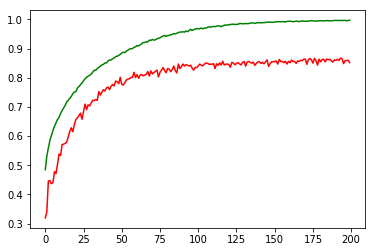

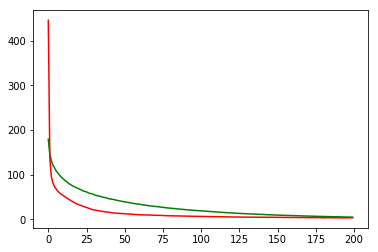

working on d,u and l 0.5 128 0.01
Non balance
Non balance
Non balance
Non balance
Non balance


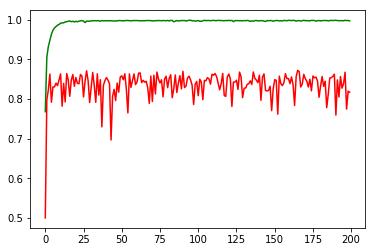

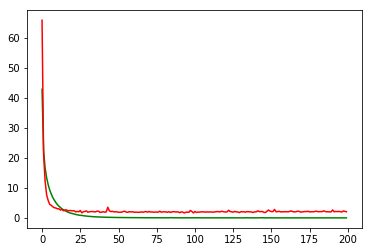

working on d,u and l 0.5 128 0.01
Non balance
Non balance
Non balance
Non balance
Non balance


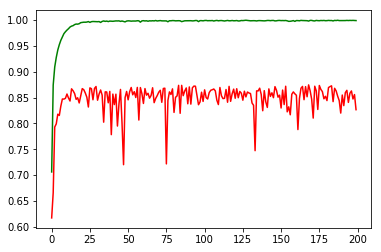

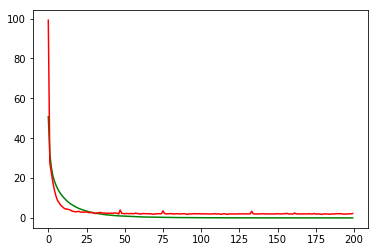

working on d,u and l 0.5 128 0.01
Non balance
Non balance
Non balance
Non balance
Non balance


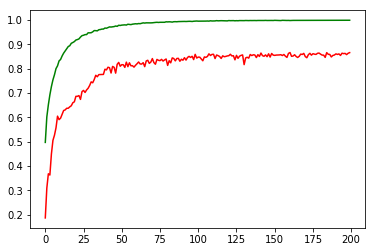

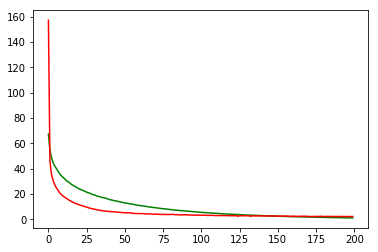

working on d,u and l 0.5 128 0.05
Non balance
Non balance
Non balance
Non balance
Non balance


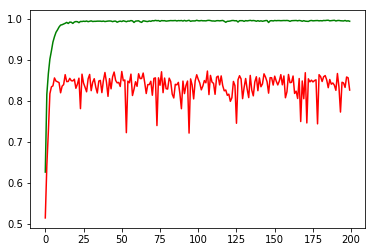

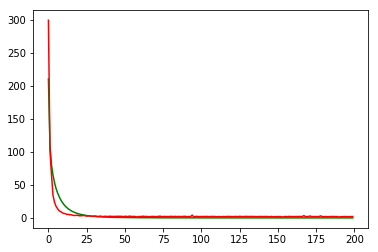

working on d,u and l 0.5 128 0.05
Non balance
Non balance
Non balance
Non balance
Non balance


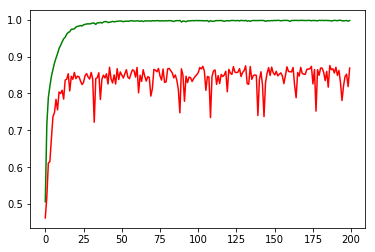

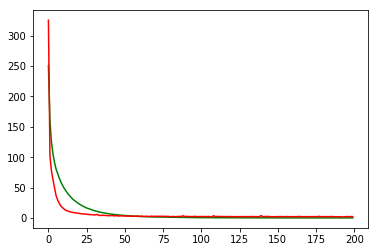

working on d,u and l 0.5 128 0.05
Non balance
Non balance
Non balance
Non balance
Non balance


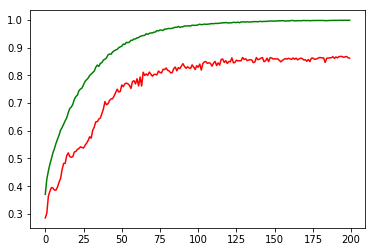

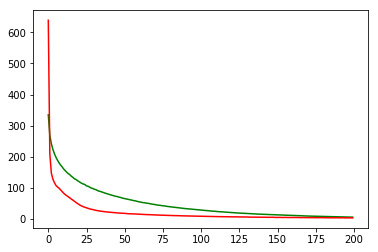

best model u,l,d,learn 0.05 128 0.5 0.0005
Chart for BEST MODEL FOR: CSCO


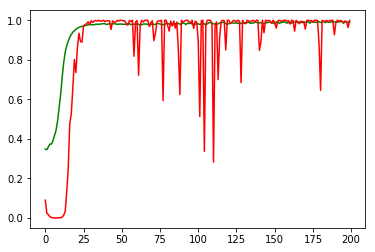

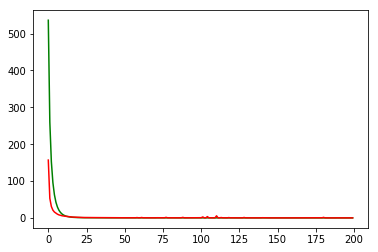

G-score: 0.47109023946312145
Accuracy 0.9991111111111111
0.9991111111111111
Window: 140
[[1124    1]
 [   0    0]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... CMCSA
10.63829787234043
0.0
working on d,u and l 0.5 64 0.01
Non balance
Non balance


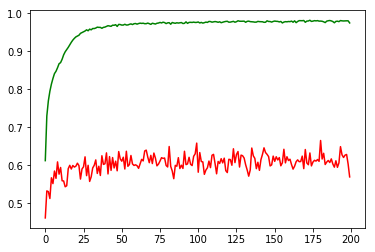

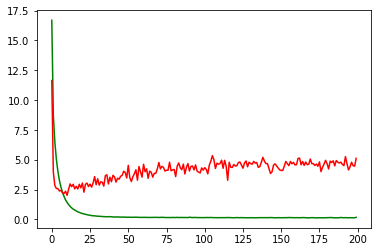

working on d,u and l 0.5 64 0.01
Non balance
Non balance


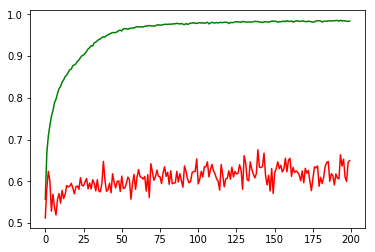

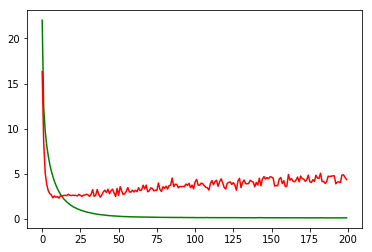

working on d,u and l 0.5 64 0.01
Non balance
Non balance


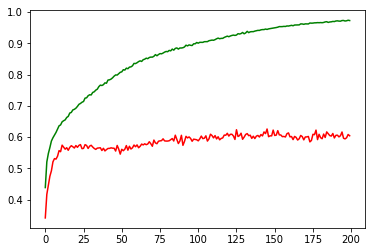

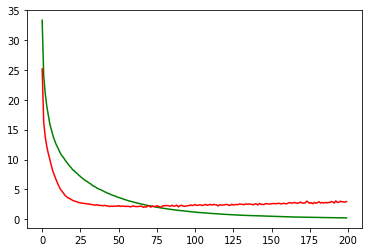

working on d,u and l 0.5 64 0.05
Non balance
Non balance


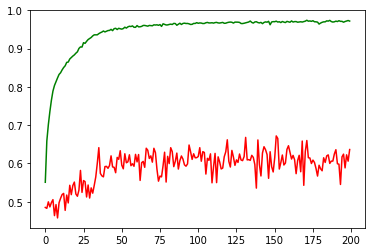

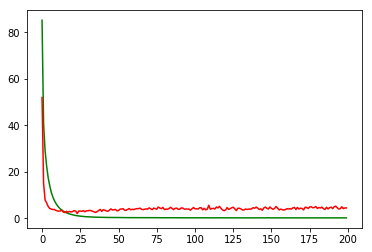

working on d,u and l 0.5 64 0.05
Non balance
Non balance


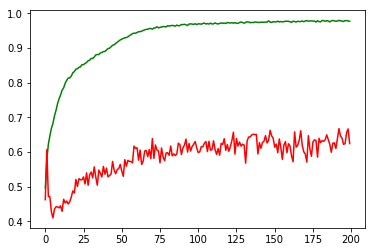

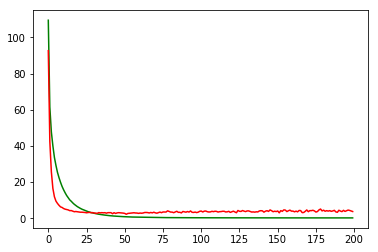

working on d,u and l 0.5 64 0.05
Non balance
Non balance


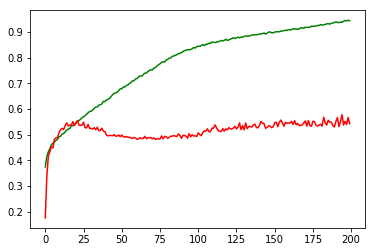

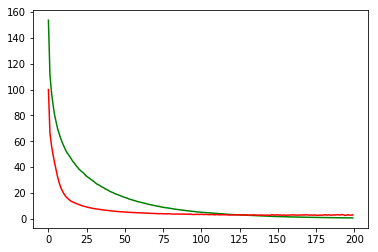

working on d,u and l 0.5 128 0.01
Non balance
Non balance


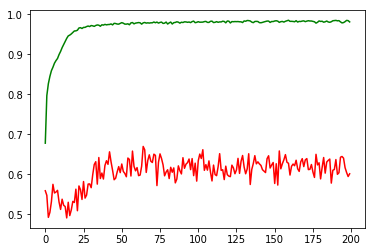

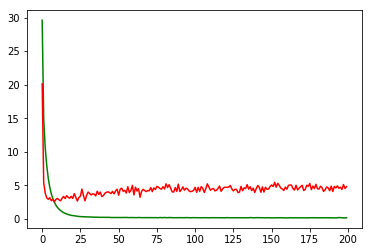

working on d,u and l 0.5 128 0.01
Non balance
Non balance


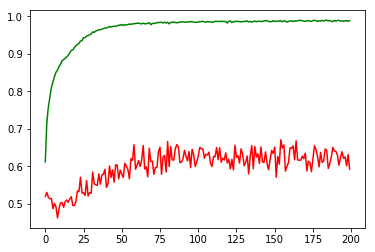

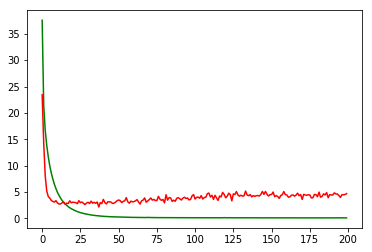

working on d,u and l 0.5 128 0.01
Non balance
Non balance


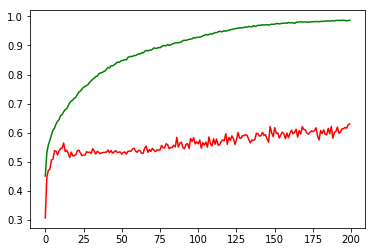

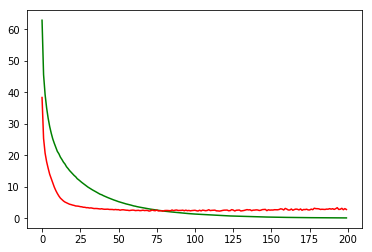

working on d,u and l 0.5 128 0.05
Non balance
Non balance


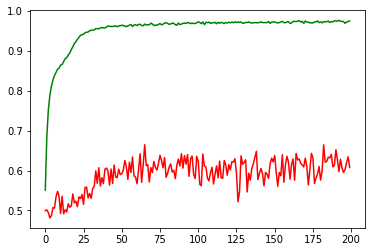

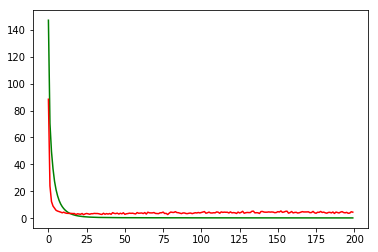

working on d,u and l 0.5 128 0.05
Non balance
Non balance


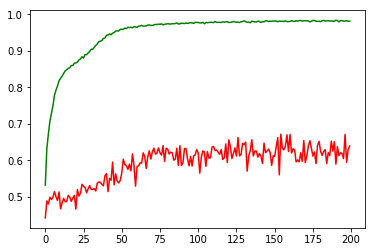

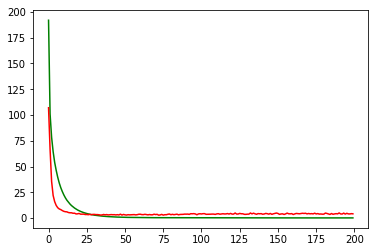

working on d,u and l 0.5 128 0.05
Non balance
Non balance


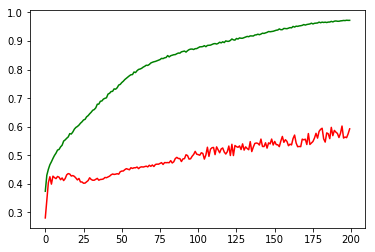

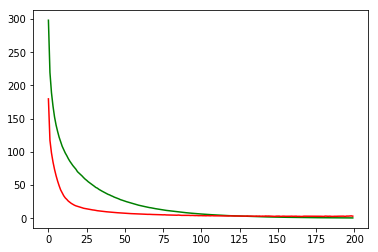

best model u,l,d,learn 0.01 64 0.5 0.0005
Chart for BEST MODEL FOR: CMCSA


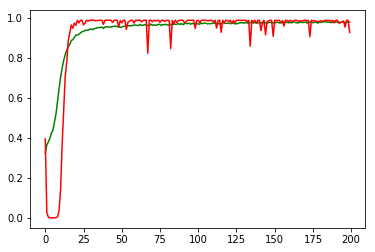

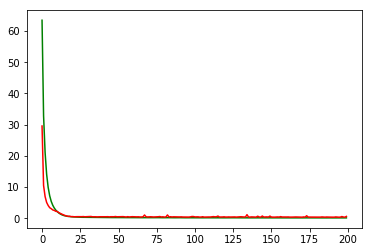

G-score: 0.4496270184121311
Accuracy 0.9275618349284249
0.9275618374558304
Window: 140
[[   0   13    0]
 [   0 1050   69]
 [   0    0    0]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... NVDA
14.360220994475142
0.0
working on d,u and l 0.5 64 0.01
Non balance


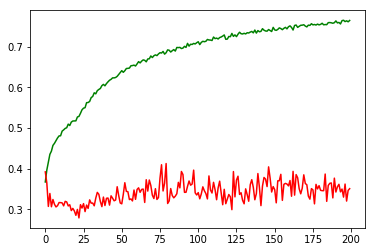

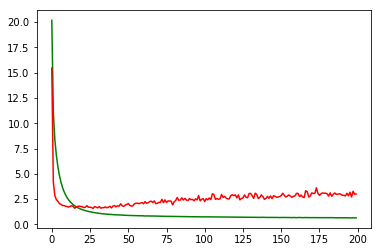

working on d,u and l 0.5 64 0.01
Non balance


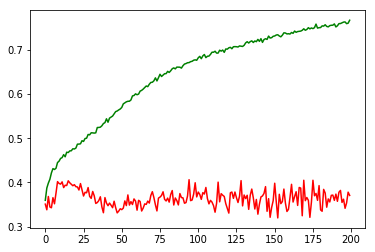

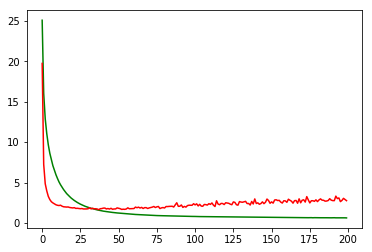

working on d,u and l 0.5 64 0.01
Non balance


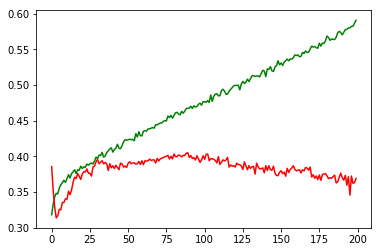

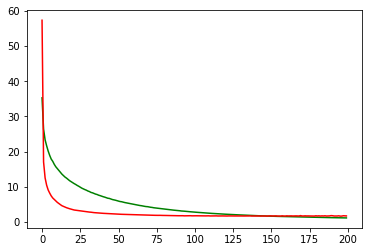

working on d,u and l 0.5 64 0.05
Non balance


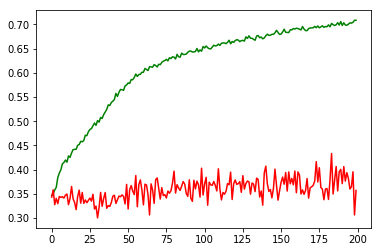

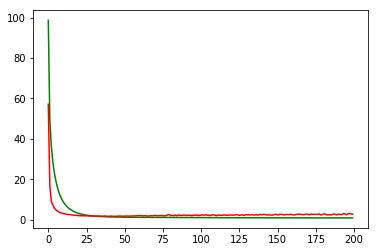

working on d,u and l 0.5 64 0.05
Non balance


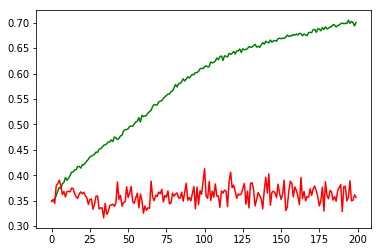

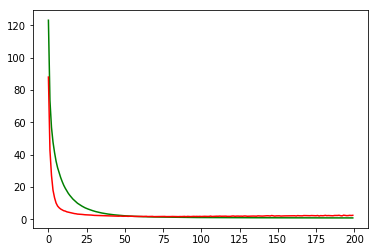

working on d,u and l 0.5 64 0.05
Non balance


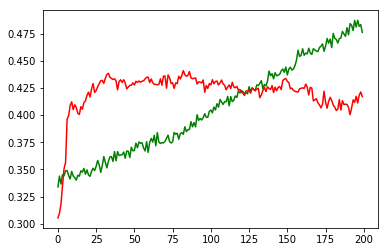

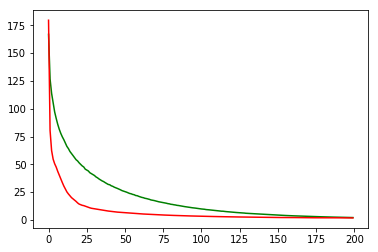

working on d,u and l 0.5 128 0.01
Non balance


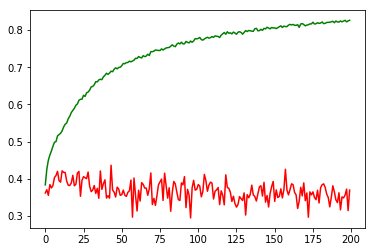

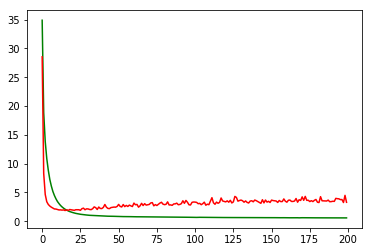

working on d,u and l 0.5 128 0.01
Non balance


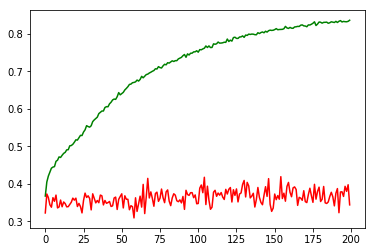

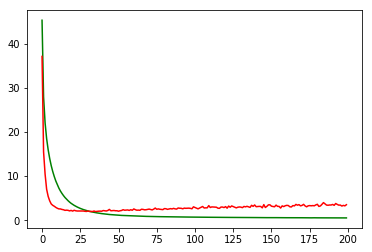

working on d,u and l 0.5 128 0.01
Non balance


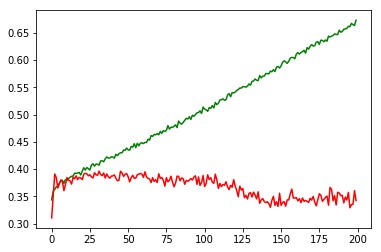

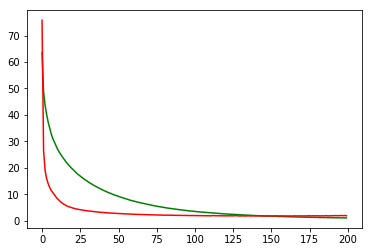

working on d,u and l 0.5 128 0.05
Non balance


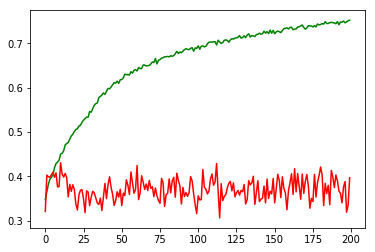

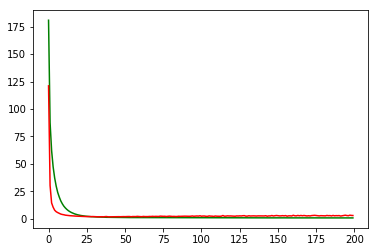

working on d,u and l 0.5 128 0.05
Non balance


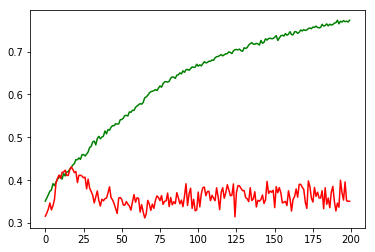

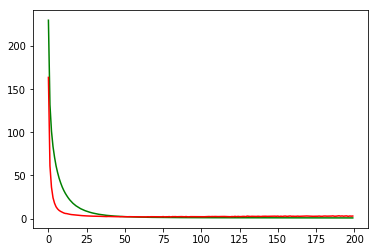

working on d,u and l 0.5 128 0.05
Non balance


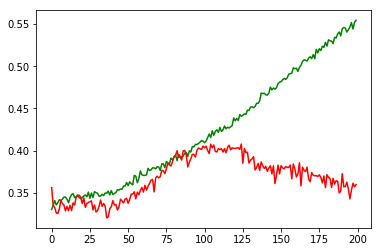

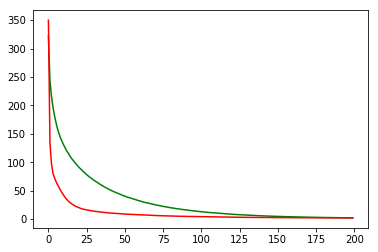

best model u,l,d,learn 0.05 128 0.5 0.001
Chart for BEST MODEL FOR: NVDA


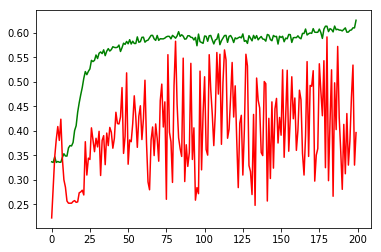

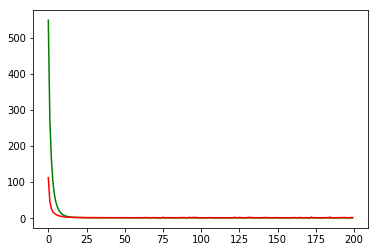

G-score: 0.5572995535070743
Accuracy 0.396643108592859
0.39664310954063603
Window: 140
[[255  13  21]
 [288  26   4]
 [335  22 168]]
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
Working on... NFLX
14.669899702413757
0.00276273621394378
working on d,u and l 0.5 64 0.01


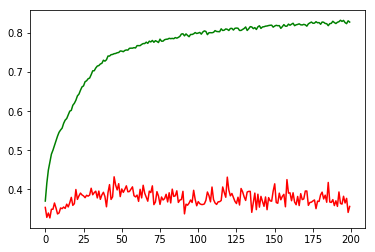

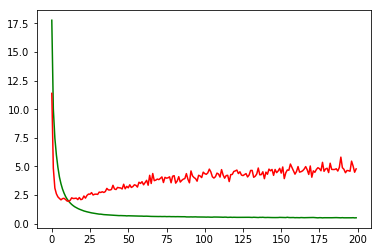

working on d,u and l 0.5 64 0.01


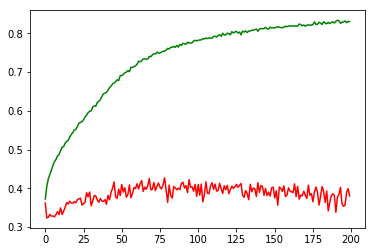

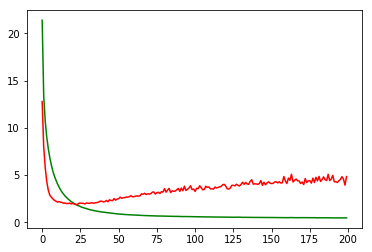

working on d,u and l 0.5 64 0.01


In [ ]:
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
o=0
accstocksresults=[]
f1stocksresults=[]
f1scoreresults=[]
aucresults=[]
chartlist=[]
gainlist=[]
pricegainlist=[]

for price in prices:
    #print('New price[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]')
    
   
    print('Working on...',files[o])
    
    senttemp=sentiment[o]
    senttemp=np.nan_to_num(np.asarray(senttemp, dtype=float))
    
    xtemp=price
    o+=1
    xtemp=np.nan_to_num(np.asarray(xtemp, dtype=float))
    
    #print(xtemp)
    accintime=[]
    trendwindowtime=[140]
    f1total=[]
    acctotal=[]
    auctotal=[]
    percfinal=[]
    f1scoretotal=[]
    percpostotal=[]
    percnegtotal=[]
    for t in trendwindowtime:
        #1
    #label because of the maket and append values without data
    #simo theroy past trend
        
        x=[]
        y=[]
        
        percentage=[]
        
        yvolatility=[]
        yprice=[]
        #print('============================================================')
        #print('Working on window:',t)
        #print(len(xtemp))
        ##QUI C E L'UNICO APPUNTO GUARDA SE CON +1 CAMBIA
        for i in range(0,len(price)-t-1):
            yvolatility.append((100*abs(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))/price.iloc[i+1]['open'])
        
        minref=min(yvolatility)
        step=(max(yvolatility)-min(yvolatility))/5
        
        for i in range(0,len(price)-t-1):
            s=np.sign(price.iloc[i+t+1]['close']-price.iloc[i+1]['open'])
            delta=abs(price.iloc[i+t+1]['close']-price.iloc[i+1]['open'])
            percentage.append((100*(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))/price.iloc[i+1]['open']) 
            if(delta<=minref+step):
                
                y.append(0)
            else:
                if(s==-1):
                    
                    y.append(-1)
                elif(s==1):
                    
                    y.append(1)
                else:
                    print('problem in labeling')
                
            
            yprice.append(abs(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))
            x.append(np.concatenate((senttemp[i],xtemp[i])))
        
        y=np.array(y)
        x=np.array(x)
        scaler = MinMaxScaler() 
        scaler.fit(x)
        MinMaxScaler(copy=True, feature_range=(0, 1))
        x=scaler.transform(x)
        yvolatility=np.array(yvolatility)
       
        permindex=range(0,len(x))
        #permindex=np.random.permutation(permindex)
        train=0.8
        nt=math.ceil(len(x)*train)
        trainvalindex=permindex[0:nt]
        testindex=permindex[nt:]
        x_tv=[]
        y_tv=[]
        x_test=[]
        y_test=[]
        x_tv=x[trainvalindex]
        y_tv=y[trainvalindex]
        x_test=x[testindex]
        y_test=y[testindex]
        yvolatilitytest=yvolatility[testindex]
        #create structure for percentile valuation
        distribution=[]
        print(max(yvolatilitytest))
        print(min(yvolatilitytest))
        step=(max(yvolatilitytest)-min(yvolatilitytest))/5
        for v in range(0,5):
            pindexes=[]
            for r in range(0,len(y_test)):
                if(yvolatilitytest[r]<min(yvolatilitytest)+step+step*v and yvolatilitytest[r]>min(yvolatilitytest)+step*v):
                    pindexes.append(r)
            distribution.append(pindexes)
    

        #learnspace=[0.01,0.005,0.001,0.0005,0.0001]
        #lspace=[0.05,0.01]
        #dropspace=[0,0.5]
        #uspace=[64,128]
        learnspace=[0.001,0.0005,0.0001]
        lspace=[0.01,0.05]
        dropspace=[0.5]
        uspace=[64,128]
        bestsvm=None
        bestca=[]
        bestcl=[]
        maxacc=0
        cvacc=0
        maxd=0
        maxu=0
        maxl=0
        maxle=0
        #print('Model Selection...')
        #model selection
        cvacc=0
        totu=0
        for d in dropspace:
            for u in uspace:
                
                for l in lspace:
                    for le in learnspace:
                    
                   
                        print('=========================================================')
                        print('working on d,u and l',d,u,l)

                        cvacclist=[]
                        #faccio cross validation
                        #start with 40% as train and 10% for validation and then i move in percentege
                        # 0-40 40-50
                        # 0-50 50-60
                        # 0-60 60-70 
                        #etc test set is completely external i do in some way error extimation changin the ticker
                        trainpoint=math.floor(len(x_tv)*0.40)
                        dimval=math.floor(trainpoint*0.25)
                        endval=trainpoint+dimval
                        model=buildModel(l,u,d,le)
                        for i in range(0,6):
                            #print('-----')
                            x_train=x_tv[0:trainpoint]
                            y_train=y_tv[0:trainpoint]
                            x_val=x_tv[trainpoint:endval]
                            y_val=y_tv[trainpoint:endval]

                            trainpoint=trainpoint+dimval
                            endval=endval+dimval

                            
                            try:
                                x_train,y_train=smote(x_train,y_train)
                                x_val,y_val=smote(x_val,y_val)
                            except:
                                print('Non balance')

                            history=model.fit(x_train, np.array(toOneHot(y_train)), epochs = 200,batch_size =128, verbose=0, validation_data=(x_val, np.array(toOneHot(y_val))),
                                              shuffle=True)
                            predictionhot=model.predict(x_val, batch_size=128, verbose=0)

                            prediction=np.zeros(len(predictionhot))

                            for el in range(0,len(predictionhot)):
                                m=np.argmax(predictionhot[el])

                                if(m==2):
                                    prediction[el]=1
                                elif(m==0):
                                    prediction[el]=-1
                                else:
                                    prediction[el]=0



                            if(i==0):
                                meanhvl=np.asarray(history.history['val_loss'])
                                meanhva=np.asarray(history.history['val_acc'])
                                meanhl=np.asarray(history.history['loss'])
                                meanha=np.asarray(history.history['acc'])

                            else:
                                meanhvl=np.add(meanhvl,history.history['val_loss'])
                                meanhva=np.add(meanhva,history.history['val_acc'])
                                meanha=np.add(meanha,history.history['acc'])
                                meanhl=np.add(meanhl,history.history['loss'])
                            #i take the last one
                            #maxAcc=history.history['val_acc'][len(history.history['val_acc'])-1]
                            #USING G SCORE AS MODEL SELECTION METRIC


                            maxAcc=geometric_mean_score(y_val, prediction,labels=[0,1,-1],average='macro')

                            cvacclist.append(maxAcc)
                            reset_weights(model)

                        cvacc=sum(cvacclist)/len(cvacclist)
                        if(cvacc>maxacc):
                            maxacc=cvacc
                            maxu=u
                            maxl=l
                            maxle=le
                            maxd=d


                        meanhvl=meanhvl/6
                        meanhva=meanhva/6
                        meanhl=meanhl/6
                        meanha=meanha/6

                        plt.plot(meanha,'g')
                        plt.plot(meanhva,'r')
                        plt.show()
                        plt.plot(meanhl,'g')
                        plt.plot(meanhvl,'r')
                        plt.show()

                        print('=========================================================')
        print('best model u,l,d,learn',maxl,maxu,maxd,maxle)
        model=buildModel(maxl,maxu,maxd,maxle)
        x_tv,y_tv=smote(x_tv,y_tv)
        history=model.fit(x_tv, np.array(toOneHot(y_tv)), epochs = 200,batch_size =128, verbose=0, validation_data=(x_test, np.array(toOneHot(y_test))),shuffle=True)
        predictionhot=model.predict(x_test, batch_size=128, verbose=0)
        prediction=np.zeros(len(predictionhot))
        for el in range(0,len(predictionhot)):
            m=np.argmax(predictionhot[el])
            if(m==2):
                prediction[el]=1
            elif(m==0):
                prediction[el]=-1
            else:
                prediction[el]=0
            
        
        
        print('=========================================================')
        print('=========================================================')
        print('=========================================================')
        print('=========================================================')
        print('Chart for BEST MODEL FOR:',files[o-1])
        plt.plot(history.history['acc'],'g')
        plt.plot(history.history['val_acc'],'r')
        plt.show()
        plt.plot(history.history['loss'],'g')
        plt.plot(history.history['val_loss'],'r')
        plt.show()
        acctotal.append(history.history['val_acc'][len(history.history['val_acc'])-1])
        confmatrix=confusion_matrix(y_test, prediction)
        
        volr=[]
        voln=[]
        pricegain=0
        for j in range(0,len(x_test)):
            if(prediction[j]==0):
                bho=0
            elif(y_test[j]==prediction[j]):
                volr.append(yvolatilitytest[j])
                pricegain=pricegain+yprice[j]
            else:
                voln.append(yvolatilitytest[j])
                pricegain=pricegain-yprice[j]
        
        
        #fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)
        #auc=metrics.auc(fpr, tpr)
        valueacc=geometric_mean_score(y_test, prediction,labels=[0,1,-1],average='macro')
        
       
        print('G-score:',valueacc)
        temp=0
        for r in range(0,len(prediction)):
            if(y_test[r]==prediction[r]):
                temp+=1
        
         
        realacc=history.history['val_acc'][len(history.history['val_acc'])-1]
        accstocksresults.append(realacc)
        print('Accuracy',realacc)
        print(temp/len(prediction))  
        print('Window:',t)
        print(confmatrix)
      
        print('000000000000000000000000000000000000000000000000')
        #performances for each percentile
        chartscore=[]
        
        print('000000000000000000000000000000000000000000000000')
print('Mean acc over portfolio:',sum(accstocksresults)/len(accstocksresults))

#print all the accuracy varing the percentile
for st in range(0,len(chartlist)):
    plt.plot(chartlist[st])
plt.show()
        
